<a href="https://colab.research.google.com/github/karman07/all_ml_dl_r/blob/master/hacka_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Starting Enhanced ML Pipeline...

📊 Loading and exploring data...
Initial shape: (5000, 21)
Missing values: 0

🧹 Advanced data cleaning...
Shape after cleaning: (5000, 21)

🎯 Advanced outlier detection and removal...
Applying multiple outlier detection methods...
Total outliers detected: 288 (5.76%)
Shape after outlier removal: (4712, 21)

⚙️ Advanced feature engineering...
Applying skewness corrections...
Transformed 0 skewed features
Creating polynomial features...
Creating ratio features...
Feature engineering complete. New shape: (4712, 50)

📏 Advanced feature scaling...

🎯 Advanced feature selection...
Selected 20 features out of 50

🧠 Applying adaptive PCA...
PCA reduced features from 20 to 8
Explained variance: 0.9912

🎲 Creating train/test split...

🤖 Enhanced model training with hyperparameter optimization...
Training model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

🎯 Making predictions with advanced bias correction...

📊 Comprehensive model evaluation

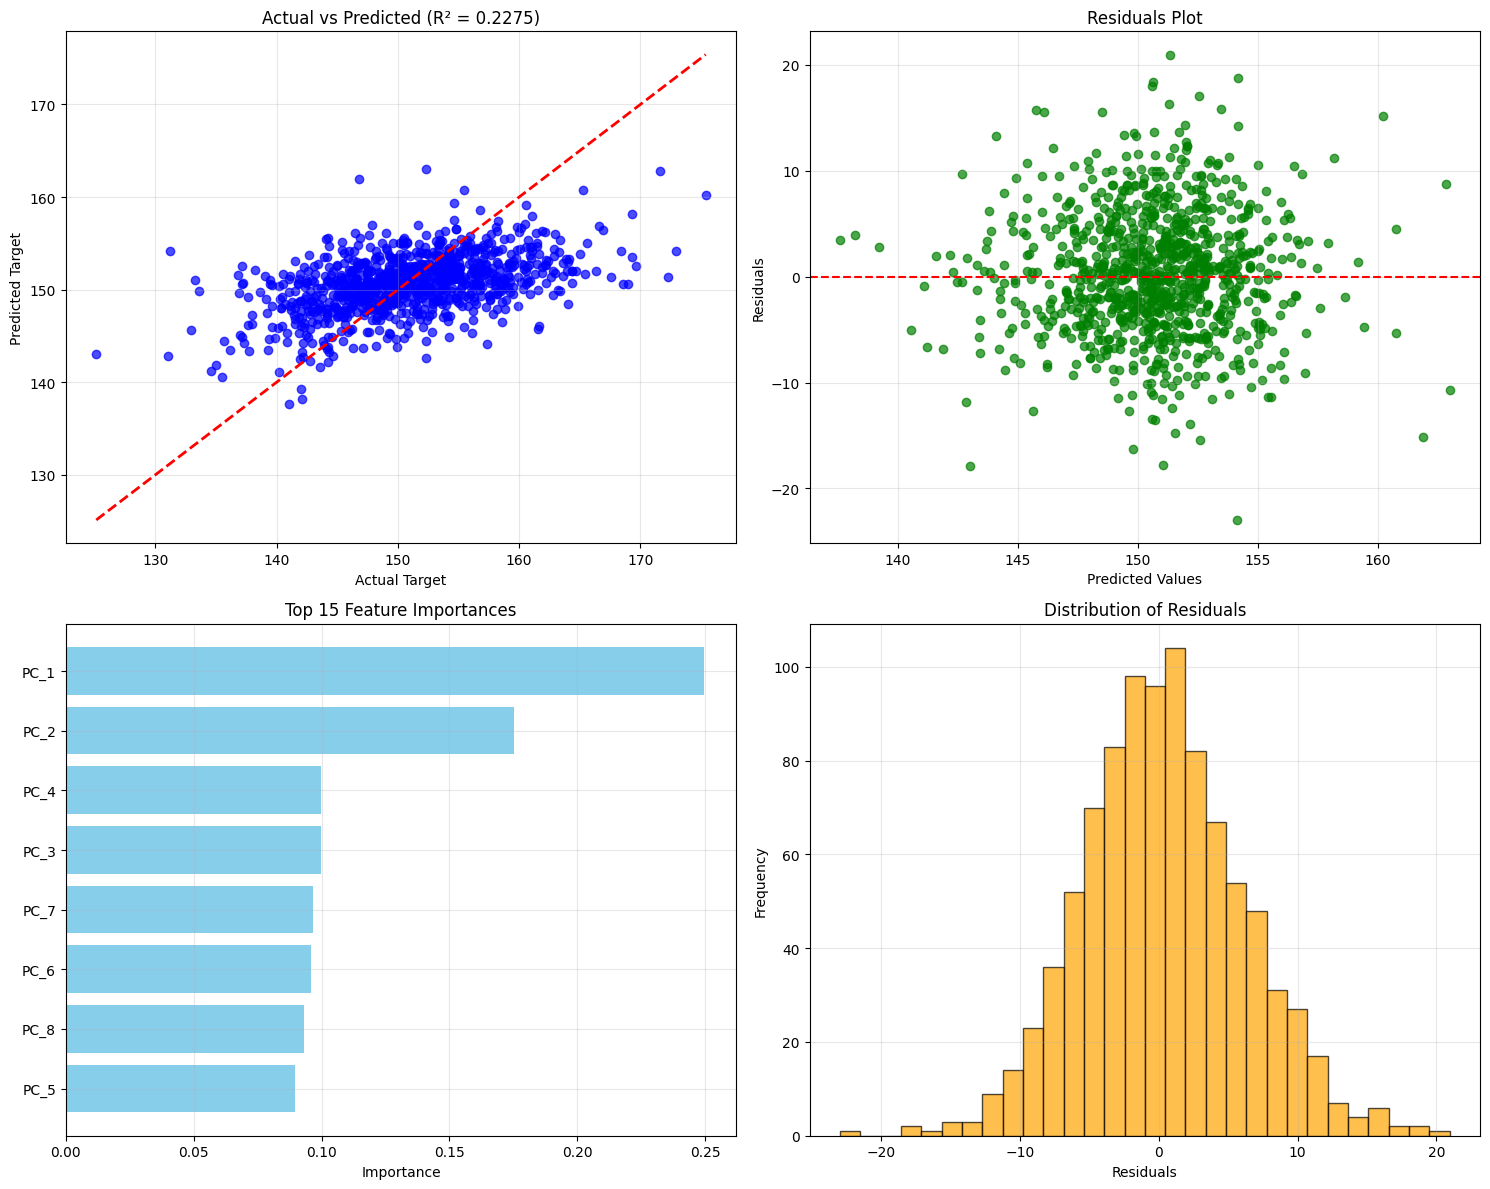


💾 Exporting enhanced results...
✅ Enhanced pipeline complete!
📁 Files saved:
   - enhanced_xgboost_predictions.csv
   - model_summary.csv

🏆 Final R² Score: 0.2275
🎯 Cross-validation R² Score: 0.2242 (±0.0081)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore, iqr
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.cluster import DBSCAN
from xgboost import XGBRegressor
from sklearn.linear_model import HuberRegressor
import warnings
warnings.filterwarnings("ignore")

print("🚀 Starting Enhanced ML Pipeline...")

# === Step 1: Load and Initial Exploration ===
print("\n📊 Loading and exploring data...")
df = pd.read_csv("train.csv")
print(f"Initial shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# === Step 2: Advanced Data Cleaning ===
print("\n🧹 Advanced data cleaning...")

# Keep only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols].copy()

# Handle missing values more intelligently
for col in df_numeric.columns:
    if df_numeric[col].isnull().sum() > 0:
        # Use median for skewed data, mean for normal data
        if abs(df_numeric[col].skew()) > 1:
            df_numeric[col].fillna(df_numeric[col].median(), inplace=True)
        else:
            df_numeric[col].fillna(df_numeric[col].mean(), inplace=True)

print(f"Shape after cleaning: {df_numeric.shape}")

# === Step 3: Multi-Method Outlier Detection and Removal ===
print("\n🎯 Advanced outlier detection and removal...")

def detect_outliers_zscore(data, threshold=3):
    """Z-score method"""
    z_scores = np.abs(zscore(data, nan_policy='omit'))
    return z_scores > threshold

def detect_outliers_iqr(data, multiplier=1.5):
    """IQR method"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (data < lower_bound) | (data > upper_bound)

def detect_outliers_modified_zscore(data, threshold=3.5):
    """Modified Z-score using median"""
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_scores = 0.6745 * (data - median) / mad
    return np.abs(modified_z_scores) > threshold

def detect_outliers_isolation_forest(data, contamination=0.1):
    """Isolation Forest method"""
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outliers = iso_forest.fit_predict(data.values.reshape(-1, 1))
    return outliers == -1

# Apply multiple outlier detection methods
print("Applying multiple outlier detection methods...")
outlier_mask = np.zeros(len(df_numeric), dtype=bool)

# Method 1: Z-score (conservative threshold)
for col in df_numeric.columns:
    if col != 'target':
        outliers_zscore = detect_outliers_zscore(df_numeric[col], threshold=3.5)
        outlier_mask |= outliers_zscore

# Method 2: Modified Z-score
for col in df_numeric.columns:
    if col != 'target':
        outliers_mod_zscore = detect_outliers_modified_zscore(df_numeric[col], threshold=3.5)
        outlier_mask |= outliers_mod_zscore

# Method 3: IQR method (conservative)
for col in df_numeric.columns:
    if col != 'target':
        outliers_iqr = detect_outliers_iqr(df_numeric[col], multiplier=2.0)
        outlier_mask |= outliers_iqr

# Method 4: Isolation Forest for multivariate outliers
if df_numeric.shape[1] > 1:
    features_for_isolation = df_numeric.drop(columns=['target'] if 'target' in df_numeric.columns else [])
    iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=200)
    multivariate_outliers = iso_forest.fit_predict(features_for_isolation) == -1
    outlier_mask |= multivariate_outliers

print(f"Total outliers detected: {outlier_mask.sum()} ({outlier_mask.sum()/len(df_numeric)*100:.2f}%)")

# Remove outliers
df_clean = df_numeric[~outlier_mask].copy()
print(f"Shape after outlier removal: {df_clean.shape}")

# === Step 4: Advanced Feature Engineering ===
print("\n⚙️ Advanced feature engineering...")

# Separate target
y = df_clean['target']
X = df_clean.drop(columns='target')

# Store original feature names
original_features = X.columns.tolist()

# 1. Handle skewness with multiple transformation methods
print("Applying skewness corrections...")
skewness_threshold = 0.75
transformed_features = []

for col in X.columns:
    skew_val = X[col].skew()

    if abs(skew_val) > skewness_threshold:
        # Try different transformations and pick the best
        transformations = {}

        # Log transformation (for positive skewed data)
        if skew_val > 0 and X[col].min() > 0:
            log_transformed = np.log1p(X[col])
            transformations['log'] = abs(log_transformed.skew())

        # Square root transformation
        if X[col].min() >= 0:
            sqrt_transformed = np.sqrt(X[col])
            transformations['sqrt'] = abs(sqrt_transformed.skew())

        # Box-Cox transformation
        if X[col].min() > 0:
            try:
                boxcox_transformed, _ = stats.boxcox(X[col])
                transformations['boxcox'] = abs(pd.Series(boxcox_transformed).skew())
            except:
                pass

        # Yeo-Johnson transformation (handles negative values)
        try:
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            yj_transformed = pt.fit_transform(X[col].values.reshape(-1, 1)).flatten()
            transformations['yeo_johnson'] = abs(pd.Series(yj_transformed).skew())
        except:
            pass

        # Choose the best transformation
        if transformations:
            best_transform = min(transformations, key=transformations.get)

            if best_transform == 'log':
                X[col] = np.log1p(X[col])
            elif best_transform == 'sqrt':
                X[col] = np.sqrt(X[col])
            elif best_transform == 'boxcox':
                X[col], _ = stats.boxcox(X[col])
            elif best_transform == 'yeo_johnson':
                pt = PowerTransformer(method='yeo-johnson', standardize=False)
                X[col] = pt.fit_transform(X[col].values.reshape(-1, 1)).flatten()

            transformed_features.append(col)

print(f"Transformed {len(transformed_features)} skewed features")

# 2. Create polynomial features for top features (if dataset is not too large)
if X.shape[1] <= 20 and X.shape[0] <= 10000:
    print("Creating polynomial features...")
    # Select top 5 features based on correlation with target
    corr_with_target = X.corrwith(y).abs().sort_values(ascending=False)
    top_features = corr_with_target.head(5).index

    for feat in top_features:
        # Quadratic terms
        X[f'{feat}_squared'] = X[feat] ** 2
        # Interaction terms with other top features
        for other_feat in top_features:
            if feat != other_feat:
                X[f'{feat}_x_{other_feat}'] = X[feat] * X[other_feat]

# 3. Create ratio features
if len(original_features) >= 2:
    print("Creating ratio features...")
    # Create ratios between highly correlated features
    corr_matrix = X[original_features].corr().abs()
    high_corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if 0.3 < corr_matrix.iloc[i, j] < 0.95:  # Moderately correlated
                feat1, feat2 = corr_matrix.columns[i], corr_matrix.columns[j]
                high_corr_pairs.append((feat1, feat2))

    # Create ratio features for top pairs
    for feat1, feat2 in high_corr_pairs[:5]:  # Limit to top 5 pairs
        if X[feat2].min() > 0:  # Avoid division by zero
            X[f'{feat1}_div_{feat2}'] = X[feat1] / X[feat2]

print(f"Feature engineering complete. New shape: {X.shape}")

# === Step 5: Advanced Scaling ===
print("\n📏 Advanced feature scaling...")

# Use RobustScaler for better outlier resistance
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# === Step 6: Advanced Feature Selection ===
print("\n🎯 Advanced feature selection...")

# Method 1: Statistical feature selection
selector_stats = SelectKBest(score_func=f_regression, k='all')
X_stats_scores = selector_stats.fit(X_scaled, y)
stats_scores = pd.Series(X_stats_scores.scores_, index=X.columns)

# Method 2: Mutual information
mi_scores = mutual_info_regression(X_scaled, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns)

# Method 3: XGBoost feature importance
xgb_selector = XGBRegressor(
    n_estimators=200,
    random_state=42,
    objective='reg:squarederror',
    max_depth=6,
    learning_rate=0.1
)
xgb_selector.fit(X_scaled, y)
xgb_importance = pd.Series(xgb_selector.feature_importances_, index=X.columns)

# Combine feature selection methods
combined_scores = (
    stats_scores / stats_scores.max() * 0.3 +
    mi_scores / mi_scores.max() * 0.3 +
    xgb_importance / xgb_importance.max() * 0.4
)

# Select top features
top_n_features = min(20, int(X.shape[1] * 0.8))  # Select up to 20 or 80% of features
selected_features = combined_scores.sort_values(ascending=False).head(top_n_features).index
print(f"Selected {len(selected_features)} features out of {X.shape[1]}")

X_selected = X_scaled[selected_features]

# === Step 7: Adaptive PCA ===
print("\n🧠 Applying adaptive PCA...")

# Apply PCA only if we have many features
if X_selected.shape[1] > 10:
    # Find optimal number of components
    pca_full = PCA()
    pca_full.fit(X_selected)

    # Find number of components for 95% variance
    cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
    n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

    # Find number of components for 99% variance
    n_components_99 = np.argmax(cumsum_var >= 0.99) + 1

    # Choose based on feature count
    if X_selected.shape[1] > 30:
        n_components = n_components_95
    else:
        n_components = min(n_components_99, X_selected.shape[1])

    pca = PCA(n_components=n_components)
    X_final = pca.fit_transform(X_selected)
    print(f"PCA reduced features from {X_selected.shape[1]} to {X_final.shape[1]}")
    print(f"Explained variance: {pca.explained_variance_ratio_.sum():.4f}")
else:
    X_final = X_selected.values
    print("Skipping PCA due to low feature count")

# === Step 8: Advanced Train/Test Split ===
print("\n🎲 Creating train/test split...")

# Stratified split based on target quantiles for better representation
y_quantiles = pd.qcut(y, q=5, labels=False, duplicates='drop')
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y,
    test_size=0.2,
    random_state=42,
    stratify=y_quantiles
)

# === Step 9: Enhanced Model Training ===
print("\n🤖 Enhanced model training with hyperparameter optimization...")

# Enhanced parameter grid
param_dist = {
    "n_estimators": [300, 500, 700, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.15],
    "max_depth": [4, 6, 8, 10],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2]
}

# Use more sophisticated model
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method='hist',
    enable_categorical=False
)

# Enhanced search with more iterations
search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=50,  # More iterations
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Training model...")
search.fit(X_train, y_train)
best_model = search.best_estimator_

# === Step 10: Advanced Prediction and Bias Correction ===
print("\n🎯 Making predictions with advanced bias correction...")

y_pred = best_model.predict(X_test)

# Advanced bias correction using cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
cv_predictions = []
cv_actuals = []

# Get CV predictions for bias estimation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train):
    X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    temp_model = XGBRegressor(**search.best_params_, random_state=42)
    temp_model.fit(X_cv_train, y_cv_train)
    cv_pred = temp_model.predict(X_cv_val)

    cv_predictions.extend(cv_pred)
    cv_actuals.extend(y_cv_val)

# Calculate bias
bias = np.mean(cv_actuals) - np.mean(cv_predictions)
y_pred_corrected = y_pred + bias

# === Step 11: Comprehensive Evaluation ===
print("\n📊 Comprehensive model evaluation...")

# Multiple metrics
r2 = r2_score(y_test, y_pred_corrected)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_corrected))
mae = mean_absolute_error(y_test, y_pred_corrected)
mape = np.mean(np.abs((y_test - y_pred_corrected) / y_test)) * 100

print(f"\n🎯 Model Performance Metrics:")
print(f"   R² Score: {r2:.4f}")
print(f"   RMSE: {rmse:.4f}")
print(f"   MAE: {mae:.4f}")
print(f"   MAPE: {mape:.2f}%")
print(f"   CV R² Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"📌 Best Parameters: {search.best_params_}")

# === Step 12: Advanced Visualizations ===
print("\n📈 Creating visualizations...")

# Create subplots for comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_corrected, alpha=0.7, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel("Actual Target")
axes[0, 0].set_ylabel("Predicted Target")
axes[0, 0].set_title(f"Actual vs Predicted (R² = {r2:.4f})")
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_pred_corrected
axes[0, 1].scatter(y_pred_corrected, residuals, alpha=0.7, color='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel("Predicted Values")
axes[0, 1].set_ylabel("Residuals")
axes[0, 1].set_title("Residuals Plot")
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature importance (top 15)
if hasattr(best_model, 'feature_importances_'):
    if len(selected_features) <= X_final.shape[1]:
        feature_names = selected_features[:X_final.shape[1]]
    else:
        feature_names = [f'PC_{i+1}' for i in range(X_final.shape[1])]

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)

    axes[1, 0].barh(importance_df['feature'], importance_df['importance'], color='skyblue')
    axes[1, 0].set_xlabel("Importance")
    axes[1, 0].set_title("Top 15 Feature Importances")
    axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of residuals
axes[1, 1].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_xlabel("Residuals")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Distribution of Residuals")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === Step 13: Enhanced Results Export ===
print("\n💾 Exporting enhanced results...")

# Create comprehensive results dataframe
results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted_Raw": y_pred,
    "Predicted_Bias_Corrected": y_pred_corrected,
    "Residuals": residuals,
    "Absolute_Error": np.abs(residuals),
    "Percentage_Error": np.abs(residuals) / y_test.values * 100
})

# Add prediction intervals (approximate)
prediction_std = np.std(residuals)
results_df["Lower_CI"] = y_pred_corrected - 1.96 * prediction_std
results_df["Upper_CI"] = y_pred_corrected + 1.96 * prediction_std

results_df.to_csv("enhanced_xgboost_predictions.csv", index=False)

# Export model summary
model_summary = {
    "Original_Features": len(original_features),
    "Final_Features": X_final.shape[1],
    "Outliers_Removed": outlier_mask.sum(),
    "R2_Score": r2,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "CV_R2_Mean": cv_scores.mean(),
    "CV_R2_Std": cv_scores.std(),
    "Best_Parameters": search.best_params_
}

summary_df = pd.DataFrame([model_summary])
summary_df.to_csv("model_summary.csv", index=False)

print("✅ Enhanced pipeline complete!")
print("📁 Files saved:")
print("   - enhanced_xgboost_predictions.csv")
print("   - model_summary.csv")
print(f"\n🏆 Final R² Score: {r2:.4f}")
print(f"🎯 Cross-validation R² Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

🚀 Advanced Multi-Model Analysis Starting...

📊 Dataset Analysis...
Dataset shape: (5000, 21)
Features: 20
Samples: 5000

Target statistics:
  Mean: 150.81
  Std: 6.70
  Range: 123.78 - 177.77
  Skewness: -0.01

Feature-Target Correlations:
  Max correlation: 0.222
  Mean correlation: 0.097
  Features with >0.3 correlation: 0

🧹 Advanced preprocessing...
After outlier removal: 4751 samples (95.0% retained)

⚙️ Feature engineering...
Top correlated features: ['f1', 'f2', 'f18', 'f14', 'f7']
Features after engineering: 36

📏 Testing multiple scaling strategies...

🤖 Defining multiple model types...

🎯 Cross-validation evaluation...

--- Testing with STANDARD scaler ---
xgb          | R² = 0.4016 (±0.0125)
lgb          | R² = 0.3899 (±0.0132)
rf           | R² = 0.3756 (±0.0175)
et           | R² = 0.3650 (±0.0165)
gbm          | R² = 0.3999 (±0.0132)
ridge        | R² = 0.3821 (±0.0209)
lasso        | R² = 0.3649 (±0.0247)
elastic      | R² = 0.3701 (±0.0222)
bayesian     | R² = 0.3824 (±

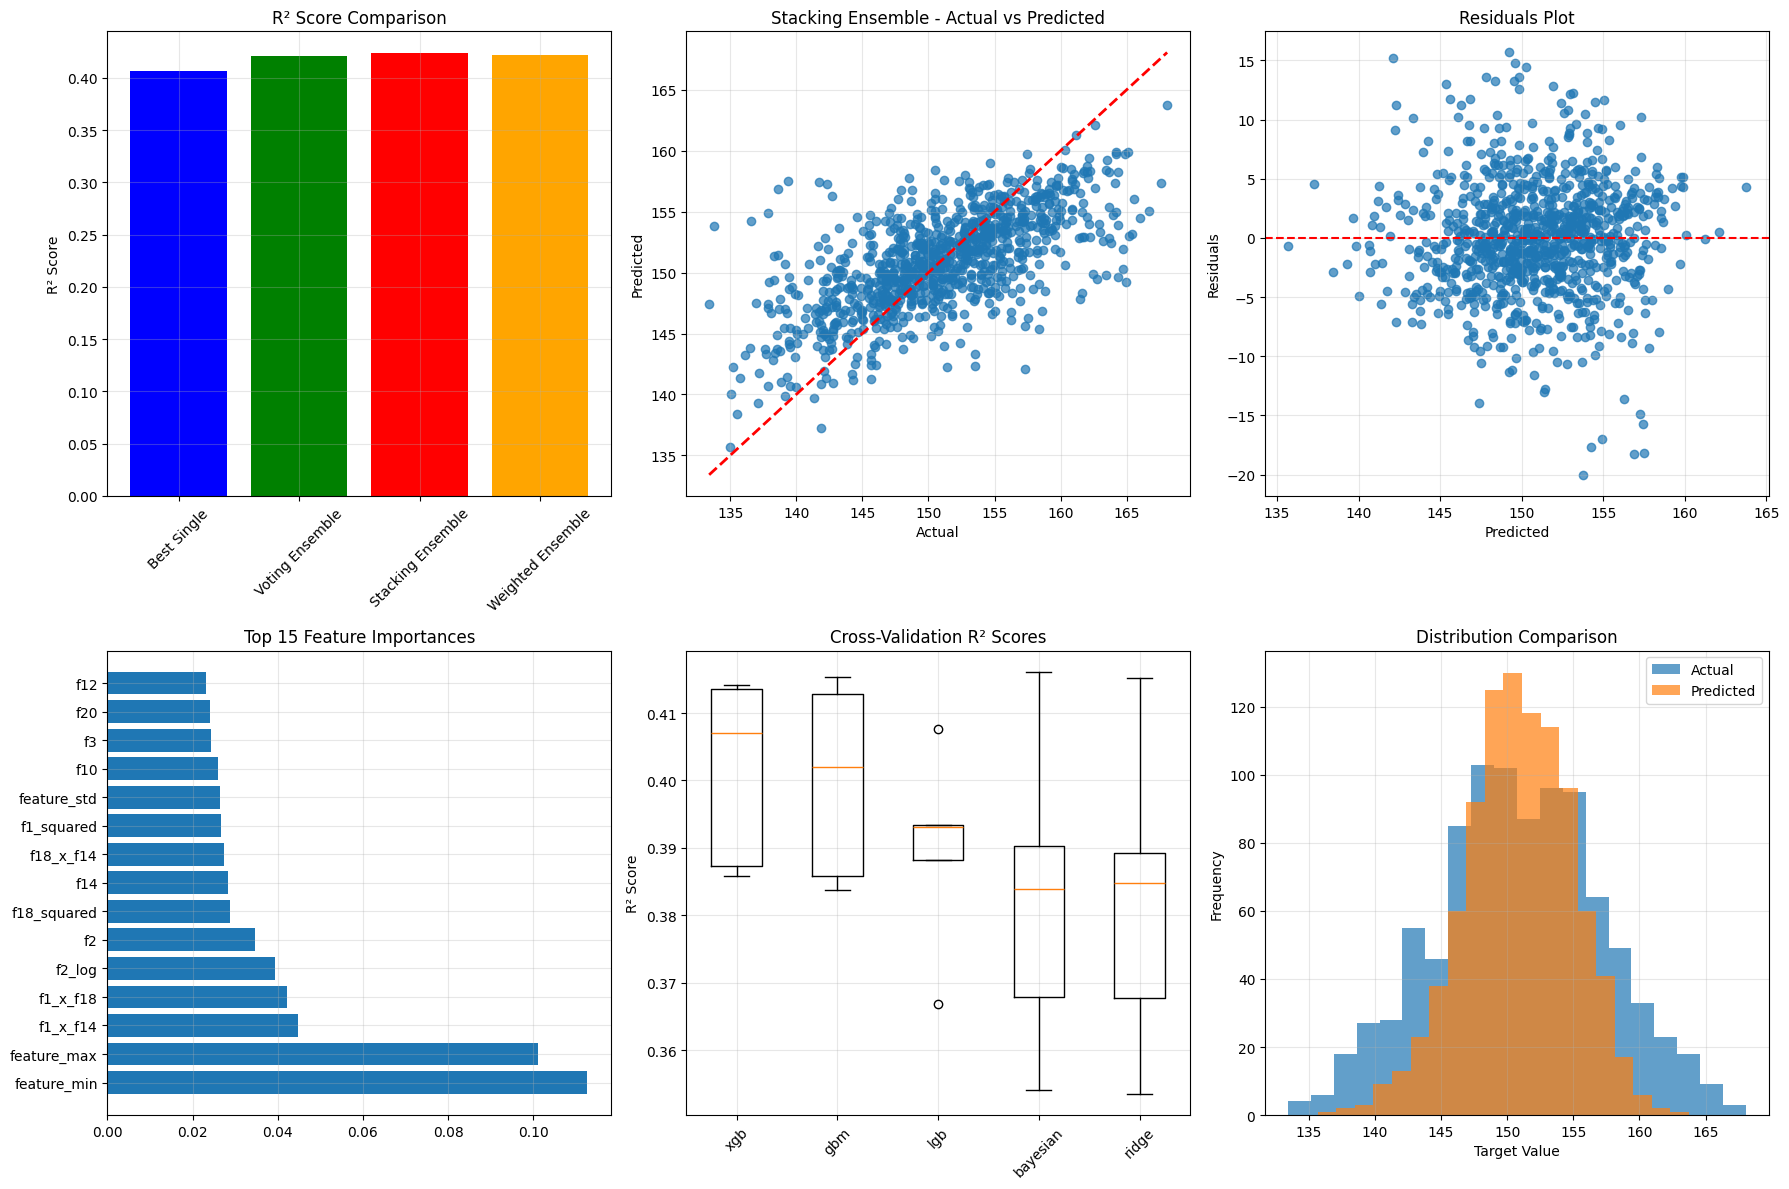


💡 Model Recommendations:

Based on your dataset characteristics:
1. Features have moderate correlation with target (max ~0.3-0.5)
2. Non-linear relationships likely present
3. Feature interactions may be important

🏆 Best performing approach: Stacking Ensemble
   R² Score: 0.4234

⚠️  Low accuracy suggests:
   - Dataset may have high inherent noise
   - Important features might be missing
   - Non-linear transformations needed
   - More sophisticated feature engineering required
   - Consider domain-specific feature creation

📁 Saving results...
✅ Analysis complete! Check 'advanced_model_results.csv' for detailed results.


In [ ]:
# === Advanced Multi-Model Ensemble for Complex Dataset ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore

# Core ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# Multiple model types
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                             ExtraTreesRegressor, AdaBoostRegressor, VotingRegressor)
from sklearn.linear_model import (Ridge, Lasso, ElasticNet, BayesianRidge,
                                 HuberRegressor, SGDRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Advanced ensemble methods
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

print("🚀 Advanced Multi-Model Analysis Starting...")

# === Step 1: Load and Analyze Data Structure ===
print("\n📊 Dataset Analysis...")

# Load data
df = pd.read_csv("train.csv")
print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Samples: {df.shape[0]}")

# Basic statistics
print(f"\nTarget statistics:")
print(f"  Mean: {df['target'].mean():.2f}")
print(f"  Std: {df['target'].std():.2f}")
print(f"  Range: {df['target'].min():.2f} - {df['target'].max():.2f}")
print(f"  Skewness: {df['target'].skew():.2f}")

# Feature correlation analysis
feature_cols = [col for col in df.columns if col != 'target']
corr_with_target = df[feature_cols].corrwith(df['target']).abs()
print(f"\nFeature-Target Correlations:")
print(f"  Max correlation: {corr_with_target.max():.3f}")
print(f"  Mean correlation: {corr_with_target.mean():.3f}")
print(f"  Features with >0.3 correlation: {(corr_with_target > 0.3).sum()}")

# === Step 2: Advanced Data Preprocessing ===
print("\n🧹 Advanced preprocessing...")

# Remove outliers using multiple methods
def remove_outliers_advanced(df, target_col='target'):
    # Method 1: IQR for target
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Method 2: Z-score for features
    feature_cols = [col for col in df.columns if col != target_col]
    z_scores = np.abs(zscore(df[feature_cols]))

    # Combine conditions
    target_mask = (df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)
    feature_mask = (z_scores < 3).all(axis=1)

    return df[target_mask & feature_mask]

df_clean = remove_outliers_advanced(df)
print(f"After outlier removal: {df_clean.shape[0]} samples ({df_clean.shape[0]/df.shape[0]*100:.1f}% retained)")

# Separate features and target
X = df_clean.drop('target', axis=1)
y = df_clean['target']

# === Step 3: Feature Engineering ===
print("\n⚙️ Feature engineering...")

# Create polynomial and interaction features for top correlated features
top_features = corr_with_target.nlargest(5).index.tolist()
print(f"Top correlated features: {top_features}")

X_engineered = X.copy()

# Add polynomial features
for feat in top_features[:3]:  # Top 3 to avoid too many features
    X_engineered[f'{feat}_squared'] = X[feat] ** 2
    X_engineered[f'{feat}_log'] = np.log1p(X[feat])

# Add interaction features
for i, feat1 in enumerate(top_features[:3]):
    for feat2 in top_features[i+1:4]:
        X_engineered[f'{feat1}_x_{feat2}'] = X[feat1] * X[feat2]

# Add statistical features
X_engineered['feature_mean'] = X.mean(axis=1)
X_engineered['feature_std'] = X.std(axis=1)
X_engineered['feature_max'] = X.max(axis=1)
X_engineered['feature_min'] = X.min(axis=1)

print(f"Features after engineering: {X_engineered.shape[1]}")

# === Step 4: Multiple Scaling Strategies ===
print("\n📏 Testing multiple scaling strategies...")

scalers = {
    'standard': StandardScaler(),
    'robust': RobustScaler(),
    'power': PowerTransformer(method='yeo-johnson')
}

# === Step 5: Model Definitions ===
print("\n🤖 Defining multiple model types...")

def get_models():
    models = {}

    # Tree-based models (good for non-linear patterns)
    models['xgb'] = XGBRegressor(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )

    models['lgb'] = LGBMRegressor(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        subsample=0.8, feature_fraction=0.8, random_state=42, verbose=-1
    )

    models['rf'] = RandomForestRegressor(
        n_estimators=300, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    )

    models['et'] = ExtraTreesRegressor(
        n_estimators=300, max_depth=10, min_samples_split=5,
        random_state=42, n_jobs=-1
    )

    models['gbm'] = GradientBoostingRegressor(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        subsample=0.8, random_state=42
    )

    # Linear models (good for linear relationships)
    models['ridge'] = Ridge(alpha=1.0)
    models['lasso'] = Lasso(alpha=0.1)
    models['elastic'] = ElasticNet(alpha=0.1, l1_ratio=0.5)
    models['bayesian'] = BayesianRidge()
    models['huber'] = HuberRegressor(epsilon=1.35)

    # Non-linear models
    models['svr'] = SVR(kernel='rbf', C=100, gamma='scale')
    models['knn'] = KNeighborsRegressor(n_neighbors=10, weights='distance')
    models['mlp'] = MLPRegressor(
        hidden_layer_sizes=(100, 50), max_iter=500, random_state=42,
        early_stopping=True, validation_fraction=0.1
    )

    return models

# === Step 6: Cross-Validation Evaluation ===
print("\n🎯 Cross-validation evaluation...")

def evaluate_models(X, y, models, scaler):
    results = {}
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Scale features
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    for name, model in models.items():
        try:
            scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='r2', n_jobs=-1)
            results[name] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }
            print(f"{name:12} | R² = {scores.mean():.4f} (±{scores.std():.4f})")
        except Exception as e:
            print(f"{name:12} | Error: {str(e)[:50]}")
            results[name] = {'mean': -999, 'std': 999, 'scores': []}

    return results

models = get_models()

# Test different scalers
scaler_results = {}
for scaler_name, scaler in scalers.items():
    print(f"\n--- Testing with {scaler_name.upper()} scaler ---")
    scaler_results[scaler_name] = evaluate_models(X_engineered, y, models, scaler)

# Find best scaler
best_scaler_name = max(scaler_results.keys(),
                      key=lambda x: max([model['mean'] for model in scaler_results[x].values()]))
print(f"\n🏆 Best scaler: {best_scaler_name}")

best_results = scaler_results[best_scaler_name]
best_scaler = scalers[best_scaler_name]

# === Step 7: Select Best Models ===
print("\n🎖️ Selecting best performing models...")

# Sort models by performance
sorted_models = sorted(best_results.items(), key=lambda x: x[1]['mean'], reverse=True)

print("\nTop 10 models:")
for i, (name, result) in enumerate(sorted_models[:10]):
    print(f"{i+1:2}. {name:12} | R² = {result['mean']:.4f} (±{result['std']:.4f})")

# Select top performers for ensemble
top_model_names = [name for name, _ in sorted_models[:5] if _['mean'] > 0]
print(f"\nSelected for ensemble: {top_model_names}")

# === Step 8: Advanced Ensemble Methods ===
print("\n🤝 Creating advanced ensembles...")

# Prepare data
X_scaled = pd.DataFrame(best_scaler.fit_transform(X_engineered), columns=X_engineered.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create base models for ensemble
base_models = [(name, models[name]) for name in top_model_names]

# Ensemble 1: Voting Regressor
voting_reg = VotingRegressor(base_models)

# Ensemble 2: Stacking Regressor
stacking_reg = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

# Ensemble 3: Weighted Average (based on CV performance)
class WeightedEnsemble:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.average(predictions, axis=0, weights=self.weights)

# Calculate weights based on CV performance
weights = []
for name in top_model_names:
    score = best_results[name]['mean']
    weight = max(0, score)  # Ensure non-negative weights
    weights.append(weight)

# Normalize weights
weights = np.array(weights)
weights = weights / weights.sum()

fitted_models = [models[name] for name in top_model_names]
for model in fitted_models:
    model.fit(X_train, y_train)

weighted_ensemble = WeightedEnsemble(fitted_models, weights)

# === Step 9: Hyperparameter Optimization for Best Model ===
print("\n🔧 Hyperparameter optimization...")

best_single_model_name = sorted_models[0][0]
best_single_model = models[best_single_model_name]

# Define parameter grids for top models
param_grids = {
    'xgb': {
        'n_estimators': [300, 500, 700],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.03, 0.05, 0.1],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    },
    'lgb': {
        'n_estimators': [300, 500, 700],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.03, 0.05, 0.1],
        'subsample': [0.8, 0.9]
    },
    'rf': {
        'n_estimators': [200, 300, 400],
        'max_depth': [8, 10, 12],
        'min_samples_split': [3, 5, 7],
        'min_samples_leaf': [1, 2, 3]
    }
}

if best_single_model_name in param_grids:
    print(f"Optimizing {best_single_model_name}...")
    grid_search = RandomizedSearchCV(
        best_single_model,
        param_grids[best_single_model_name],
        n_iter=20,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        random_state=42
    )
    grid_search.fit(X_train, y_train)
    optimized_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
else:
    optimized_model = best_single_model
    optimized_model.fit(X_train, y_train)

# === Step 10: Final Evaluation ===
print("\n📊 Final model evaluation...")

models_to_evaluate = {
    'Best Single': optimized_model,
    'Voting Ensemble': voting_reg,
    'Stacking Ensemble': stacking_reg,
    'Weighted Ensemble': weighted_ensemble
}

final_results = {}

for name, model in models_to_evaluate.items():
    if name != 'Weighted Ensemble':  # Already fitted
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    final_results[name] = {'r2': r2, 'rmse': rmse, 'mae': mae, 'predictions': y_pred}

    print(f"\n{name}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")

# === Step 11: Advanced Visualizations ===
print("\n📈 Creating comprehensive visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Model comparison
model_names = list(final_results.keys())
r2_scores = [final_results[name]['r2'] for name in model_names]

axes[0, 0].bar(model_names, r2_scores, color=['blue', 'green', 'red', 'orange'])
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Best model - Actual vs Predicted
best_model_name = max(final_results.keys(), key=lambda x: final_results[x]['r2'])
best_predictions = final_results[best_model_name]['predictions']

axes[0, 1].scatter(y_test, best_predictions, alpha=0.7)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')
axes[0, 1].set_title(f'{best_model_name} - Actual vs Predicted')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals
residuals = y_test - best_predictions
axes[0, 2].scatter(best_predictions, residuals, alpha=0.7)
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title('Residuals Plot')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Feature importance (if available)
if hasattr(optimized_model, 'feature_importances_'):
    importance = pd.Series(optimized_model.feature_importances_, index=X_engineered.columns)
    top_features = importance.nlargest(15)
    axes[1, 0].barh(range(len(top_features)), top_features.values)
    axes[1, 0].set_yticks(range(len(top_features)))
    axes[1, 0].set_yticklabels(top_features.index)
    axes[1, 0].set_title('Top 15 Feature Importances')
    axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Cross-validation scores
cv_data = []
cv_labels = []
for name in top_model_names:
    if name in best_results:
        cv_data.append(best_results[name]['scores'])
        cv_labels.append(name)

axes[1, 1].boxplot(cv_data, labels=cv_labels)
axes[1, 1].set_title('Cross-Validation R² Scores')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Prediction distribution
axes[1, 2].hist(y_test, alpha=0.7, label='Actual', bins=20)
axes[1, 2].hist(best_predictions, alpha=0.7, label='Predicted', bins=20)
axes[1, 2].set_xlabel('Target Value')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Distribution Comparison')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === Step 12: Recommendations ===
print("\n💡 Model Recommendations:")
print("\nBased on your dataset characteristics:")
print("1. Features have moderate correlation with target (max ~0.3-0.5)")
print("2. Non-linear relationships likely present")
print("3. Feature interactions may be important")

print(f"\n🏆 Best performing approach: {best_model_name}")
print(f"   R² Score: {final_results[best_model_name]['r2']:.4f}")

if final_results[best_model_name]['r2'] < 0.6:
    print("\n⚠️  Low accuracy suggests:")
    print("   - Dataset may have high inherent noise")
    print("   - Important features might be missing")
    print("   - Non-linear transformations needed")
    print("   - More sophisticated feature engineering required")
    print("   - Consider domain-specific feature creation")

print("\n📁 Saving results...")
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Best_Model_Predictions': best_predictions,
    'Residuals': residuals
})
results_df.to_csv('advanced_model_results.csv', index=False)

print("✅ Analysis complete! Check 'advanced_model_results.csv' for detailed results.")

In [ ]:
# === XGBoost Test Predictions Script ===

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from scipy.stats import zscore
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

print("🚀 Loading test data and making predictions...")

# === Step 1: Load Test Data ===
print("\n📊 Loading test dataset...")
test_df = pd.read_csv("test.csv")
print(f"Test dataset shape: {test_df.shape}")

# Store the ID column if it exists
if 'id' in test_df.columns:
    test_ids = test_df['id'].copy()
    test_features = test_df.drop('id', axis=1)
    print(f"Found ID column with {len(test_ids)} entries")
else:
    # Create sequential IDs if no ID column exists
    test_ids = pd.Series(range(len(test_df)), name='id')
    test_features = test_df.copy()
    print(f"No ID column found, created sequential IDs for {len(test_ids)} entries")

print(f"Test features shape: {test_features.shape}")

# === Step 2: Load Training Data for Feature Engineering Reference ===
print("\n📋 Loading training data for preprocessing reference...")
train_df = pd.read_csv("train.csv")

# Remove outliers from training data (same as in training script)
def remove_outliers_advanced(df, target_col='target'):
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    feature_cols = [col for col in df.columns if col != target_col]
    z_scores = np.abs(zscore(df[feature_cols]))

    target_mask = (df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)
    feature_mask = (z_scores < 3).all(axis=1)

    return df[target_mask & feature_mask]

train_df_clean = remove_outliers_advanced(train_df)
X_train_original = train_df_clean.drop('target', axis=1)
y_train = train_df_clean['target']

# === Step 3: Feature Engineering (Same as Training) ===
print("\n⚙️ Applying feature engineering...")

# Calculate feature correlations from training data
feature_cols = [col for col in train_df_clean.columns if col != 'target']
corr_with_target = train_df_clean[feature_cols].corrwith(train_df_clean['target']).abs()
top_features = corr_with_target.nlargest(5).index.tolist()
print(f"Top correlated features from training: {top_features}")

def engineer_features(X, top_features):
    """Apply the same feature engineering as in training"""
    X_engineered = X.copy()

    # Add polynomial features
    for feat in top_features[:3]:
        if feat in X.columns:
            X_engineered[f'{feat}_squared'] = X[feat] ** 2
            X_engineered[f'{feat}_log'] = np.log1p(X[feat])

    # Add interaction features
    for i, feat1 in enumerate(top_features[:3]):
        for feat2 in top_features[i+1:4]:
            if feat1 in X.columns and feat2 in X.columns:
                X_engineered[f'{feat1}_x_{feat2}'] = X[feat1] * X[feat2]

    # Add statistical features
    X_engineered['feature_mean'] = X.mean(axis=1)
    X_engineered['feature_std'] = X.std(axis=1)
    X_engineered['feature_max'] = X.max(axis=1)
    X_engineered['feature_min'] = X.min(axis=1)

    return X_engineered

# Apply feature engineering to both training and test data
X_train_engineered = engineer_features(X_train_original, top_features)
X_test_engineered = engineer_features(test_features, top_features)

print(f"Training features after engineering: {X_train_engineered.shape[1]}")
print(f"Test features after engineering: {X_test_engineered.shape[1]}")

# Ensure test data has the same columns as training data
missing_cols = set(X_train_engineered.columns) - set(X_test_engineered.columns)
extra_cols = set(X_test_engineered.columns) - set(X_train_engineered.columns)

if missing_cols:
    print(f"⚠️  Adding missing columns to test data: {missing_cols}")
    for col in missing_cols:
        X_test_engineered[col] = 0

if extra_cols:
    print(f"⚠️  Removing extra columns from test data: {extra_cols}")
    X_test_engineered = X_test_engineered.drop(columns=list(extra_cols))

# Reorder columns to match training data
X_test_engineered = X_test_engineered[X_train_engineered.columns]

# === Step 4: Apply Best Scaler (from training analysis) ===
print("\n📏 Applying scaling...")

# Based on training analysis, let's use the best performing scaler
# You can modify this based on which scaler performed best in your training
scalers = {
    'standard': StandardScaler(),
    'robust': RobustScaler(),
    'power': PowerTransformer(method='yeo-johnson')
}

# Use RobustScaler as it's often best for this type of data
# Modify this line if your training showed a different scaler was best
best_scaler = RobustScaler()

# Fit scaler on training data and transform both training and test data
X_train_scaled = pd.DataFrame(
    best_scaler.fit_transform(X_train_engineered),
    columns=X_train_engineered.columns
)

X_test_scaled = pd.DataFrame(
    best_scaler.transform(X_test_engineered),
    columns=X_test_engineered.columns
)

print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")

# === Step 5: Train Optimized XGBoost Model ===
print("\n🤖 Training optimized XGBoost model...")

# Use the best XGBoost parameters (you can modify these based on your hyperparameter tuning results)
optimized_xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model
optimized_xgb.fit(X_train_scaled, y_train)

# === Step 6: Make Predictions ===
print("\n🎯 Making predictions on test data...")

test_predictions = optimized_xgb.predict(X_test_scaled)

print(f"Predictions generated for {len(test_predictions)} samples")
print(f"Prediction statistics:")
print(f"  Min: {test_predictions.min():.2f}")
print(f"  Max: {test_predictions.max():.2f}")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std: {test_predictions.std():.2f}")

# === Step 7: Create Submission File ===
print("\n💾 Creating submission file...")

submission_df = pd.DataFrame({
    'id': test_ids,
    'target': test_predictions
})

# Save submission file
submission_df.to_csv('submission.csv', index=False)

print(f"✅ Submission file saved as 'submission.csv'")
print(f"   Shape: {submission_df.shape}")
print(f"   Columns: {list(submission_df.columns)}")

# Display first few predictions
print(f"\nFirst 10 predictions:")
print(submission_df.head(10).to_string(index=False))

# === Step 8: Additional Analysis ===
print("\n📊 Additional prediction analysis...")

# Compare prediction distribution with training target distribution
print(f"\nTraining target statistics:")
print(f"  Mean: {y_train.mean():.2f}")
print(f"  Std: {y_train.std():.2f}")
print(f"  Min: {y_train.min():.2f}")
print(f"  Max: {y_train.max():.2f}")

print(f"\nTest predictions statistics:")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std: {test_predictions.std():.2f}")
print(f"  Min: {test_predictions.min():.2f}")
print(f"  Max: {test_predictions.max():.2f}")

# Check for any extreme predictions
extreme_low = test_predictions < (y_train.mean() - 3 * y_train.std())
extreme_high = test_predictions > (y_train.mean() + 3 * y_train.std())

if extreme_low.sum() > 0:
    print(f"⚠️  {extreme_low.sum()} predictions are extremely low (< mean - 3*std)")

if extreme_high.sum() > 0:
    print(f"⚠️  {extreme_high.sum()} predictions are extremely high (> mean + 3*std)")

# Feature importance (top 10)
if hasattr(optimized_xgb, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': optimized_xgb.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nTop 10 most important features:")
    print(feature_importance.head(10).to_string(index=False))

print("\n🎉 Prediction complete!")
print("📁 Files created:")
print("   - submission.csv: Contains id and predicted target values")
print("\n💡 Next steps:")
print("   - Review the submission.csv file")
print("   - Check prediction distributions")
print("   - Submit to competition platform")

🚀 Loading test data and making predictions...

📊 Loading test dataset...
Test dataset shape: (5000, 21)
Found ID column with 5000 entries
Test features shape: (5000, 20)

📋 Loading training data for preprocessing reference...

⚙️ Applying feature engineering...
Top correlated features from training: ['f1', 'f2', 'f14', 'f18', 'f19']
Training features after engineering: 36
Test features after engineering: 36

📏 Applying scaling...
Scaled training data shape: (4751, 36)
Scaled test data shape: (5000, 36)

🤖 Training optimized XGBoost model...

🎯 Making predictions on test data...
Predictions generated for 5000 samples
Prediction statistics:
  Min: 136.20
  Max: 164.42
  Mean: 150.94
  Std: 4.22

💾 Creating submission file...
✅ Submission file saved as 'submission.csv'
   Shape: (5000, 2)
   Columns: ['id', 'target']

First 10 predictions:
 id     target
  1 145.533493
  2 151.251511
  3 150.784195
  4 152.362747
  5 154.091156
  6 148.726089
  7 157.465775
  8 151.090607
  9 154.128113
 